- What does the pattern look like?
- What is the nature of the distribution of points?
- Is there any structure in the way locations are arranged over space? That is, are events clustered? or are they dispersed?
- Why do events occur in those places and not in others?

In [1]:
import numpy
import pandas
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [5]:
db = pandas.read_csv("./geo_data/tokyo_clean.csv")
db

user_id   longitude   latitude             date_taken  \
0        10727420@N00  139.700499  35.674000  2010-04-09 17:26:25.0   
1         8819274@N04  139.766521  35.709095  2007-02-10 16:08:40.0   
2        62068690@N00  139.765632  35.694482  2008-12-21 15:45:31.0   
3     49503094041@N01  139.784391  35.548589  2011-11-11 05:48:54.0   
4        40443199@N00  139.768753  35.671521  2006-04-06 16:42:49.0   
...               ...         ...        ...                    ...   
9995     26981415@N00  139.582672  35.532785  2007-10-29 17:06:59.0   
9996     36516818@N00  139.749461  35.696870  2006-08-26 13:59:06.0   
9997     92996378@N00  139.770298  35.670336  2007-03-19 16:37:15.0   
9998     95795770@N00  139.739075  35.642470  2008-08-13 17:12:36.0   
9999     28005758@N00  139.759826  35.686860  2010-05-19 19:07:44.0   

                                   photo/video_page_url             x  \
0     http://www.flickr.com/photos/10727420@N00/4545...  1.555139e+07   
1     http://www.flickr.com/photos/8819274@N04/26503...  1.555874e+07   
2     http://www.flickr.com/photos/62068690@N00/3125...  1.555864e+07   
3     http://www.flickr.com/photos/49503094041@N01/6...  1.556073e+07   
4     http://www.flickr.com/photos/40443199@N00/2482...  1.555899e+07   
...                                                 ...           ...   
9995  http://www.flickr.com/photos/26981415@N00/1797...  1.553827e+07   
9996  http://www.flickr.com/photos/36516818@N00/2623...  1.555684e+07   
9997  http://www.flickr.com/photos/92996378@N00/4321...  1.555916e+07   
9998  http://www.flickr.com/photos/95795770@N00/2759...  1.555568e+07   
9999  http://www.flickr.com/photos/28005758@N00/4625...  1.555799e+07   

                 y  
0     4.255856e+06  
1     4.260667e+06  
2     4.258664e+06  
3     4.238684e+06  
4     4.255517e+06  
...            ...  
9995  4.236522e+06  
9996  4.258991e+06  
9997  4.255354e+06  
9998  4.251537e+06  
9999  4.257619e+06  

[10000 rows x 7 columns]

In [6]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   photo/video_page_url  10000 non-null  object 
 5   x                     10000 non-null  float64
 6   y                     10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


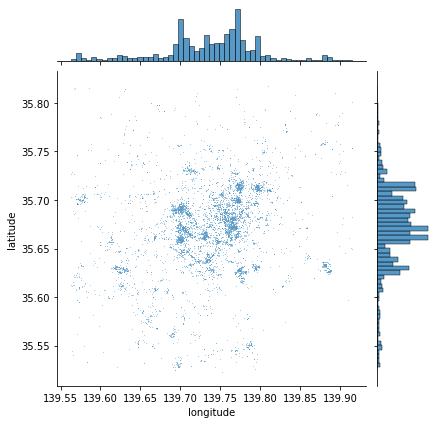

In [7]:
# Generate scatter plot
seaborn.jointplot(x="longitude", y="latitude", data=db, s=0.5);

- Dots tend to be concentrated in the center of the covered area in a non-random pattern. Furthermore, within the broad pattern, we can also see there seems to be more localized clusters. 

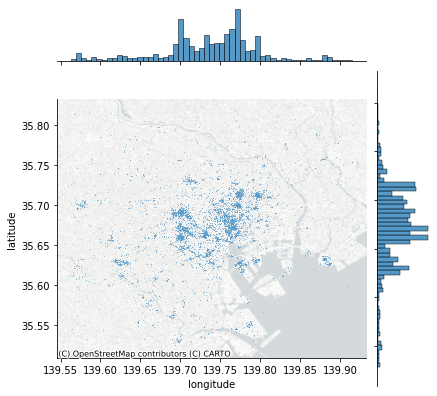

In [8]:
# Add contextily

# Generate scatter plot
joint_axes = seaborn.jointplot(
    x="longitude", y="latitude", data=db, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

In [9]:
#CRS as WGS84, since we are plotting longitude and latitude

- ###  Showing density with the Hexbinning

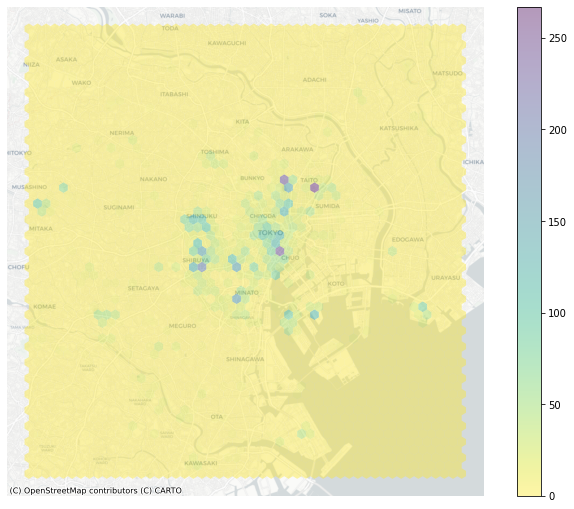

In [16]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap

hb = ax.hexbin(db['x'], db['y'], gridsize=50, linewidths=0, alpha=0.4, cmap="viridis_r")

# add basemap

contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)

# add color bar

plt.colorbar(hb)

# remove axes

ax.set_axis_off()


### Another Kind of Density: Kernel Density Estimation (KDE)

- KDE: an empirical approximation of the probability density function. 
- KDE lays a grid of points over the space of interest on which it places kernel functions that count points around them with different weight based on the distance
- These counts are then aggregated to generate a global surface with probability

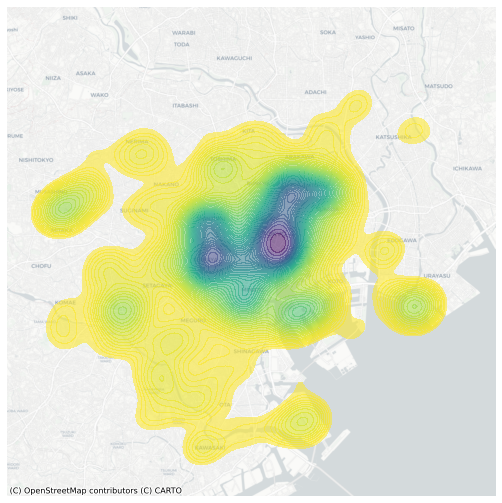

In [22]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    x=db["x"],
    y=db["y"],
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r"
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

## Centrography

- Centrography is the analysis of centrality in a point pattern. By “centrality,” we mean the general location and dispersion of the pattern.
- By “centrality,” we mean the general location and dispersion of the pattern. 

## Tendency

- Common measure of central tendency for a point pattern is its center of mass
- the center of mass identifies a central point close to observations that have higher values in their marked attribute
-  mean center, or average of the coordinate values
- the median center is analogous to the median elsewhere, and represents a point where half of the data is above or below the point & half is to its left or right

In [23]:
from pointpats import centrography

In [24]:
mean_center = centrography.mean_center(db[["x", "y"]])
med_center = centrography.euclidean_median(db[["x", "y"]])

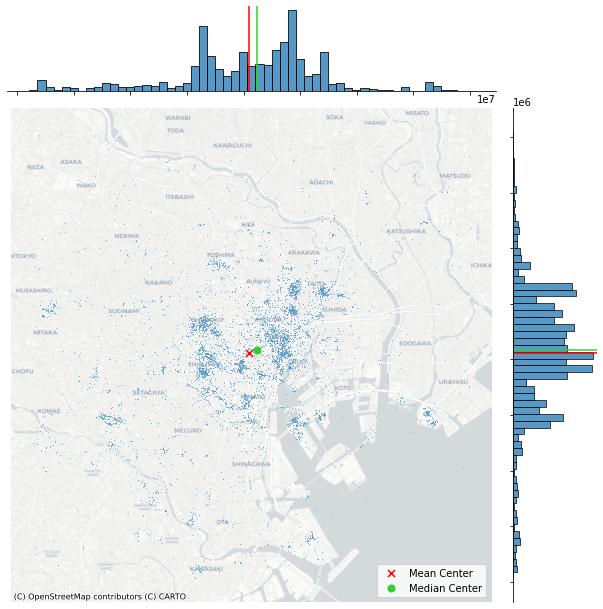

In [30]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x="x", y="y", data=db, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

- clusters” of pictures far out in West and South Tokyo, whereas North and East Tokyo is densely packed, but drops off very quickly

## Dispersion

- A measure of dispersion that is common in centrography is the standard distance. This measure provides the average distance away from the center of the point cloud (such as measured by the center of mass). This is also simple to compute using pointpats, using the std_distance function:

In [32]:
centrography.std_distance(db[["x", "y"]])

8778.218564382098

- This means that, on average, pictures are taken around 8800 meters away from the mean center.

#### Standard deviational ellipse, or standard ellipse. This is an ellipse drawn from the data that reflects its center, dispersion, and orientation

In [33]:
major, minor, rotation = centrography.ellipse(db[["x", "y"]])

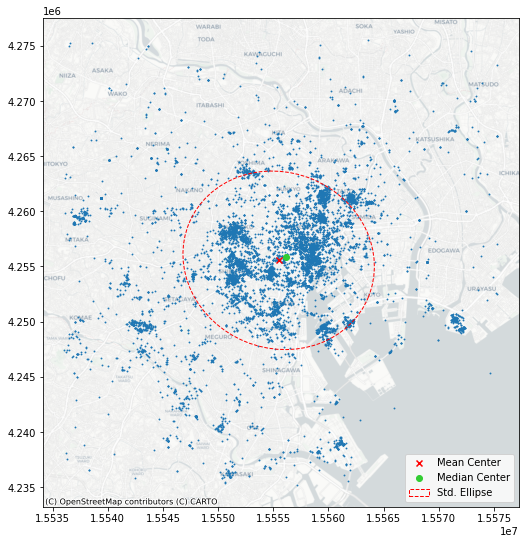

In [36]:
from matplotlib.patches import Ellipse

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot photograph points
ax.scatter(db["x"], db["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=numpy.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
plt.show()

## Extent

In [38]:
user = db.query('user_id == "95795770@N00"')
coordinates = user[["x", "y"]].values

- 1. First, we’ll compute the convex hull, which is the tightest convex shape that encloses the user’s photos. By convex, we mean that the shape never “doubles back” on itself; it has no divets, valleys, crenelations, or holes. All of its interior angles are smaller than 180 degrees. 

In [40]:
convex_hull_vertices = centrography.hull(coordinates)

- 2. Second, we’ll compute the alpha shape, which can be understood as a “tighter” version of the convex hull. One way to think of a convex hull is that it’s the space left over when rolling a really large ball or circle all the way around the shape.

In [41]:
import libpysal

alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(
    coordinates, return_circles=True
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(


To illustrate, the figure below has the tightest single alpha shape shown in green and the original source points shown in black. The “bounding” circles shown in the figure all have a radius of 8652 meters. The circles are plotted where our “bounding” disk touches two or three of the points in the point cloud. You can see that the circles “cut into” the convex hull, shown in blue dashed lines, up until they touch two (or three) points. Any tighter, and the circle would disconnect one of the points on the boundary of the alpha shape.

In [44]:
type(coordinates)

numpy.ndarray

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


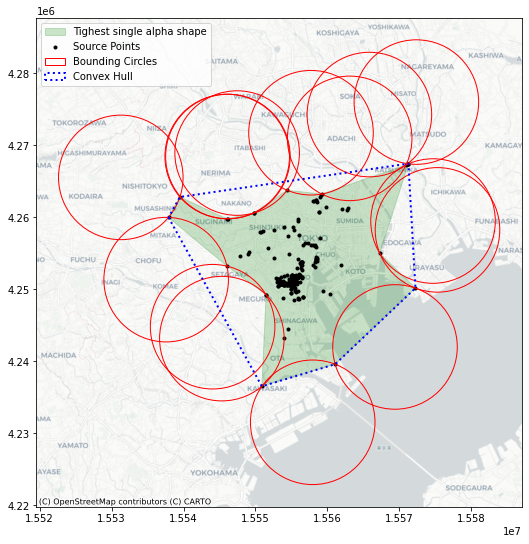

In [42]:
from descartes import PolygonPatch  # to plot the alpha shape easily

f, ax = plt.subplots(1, 1, figsize=(9, 9))

# Plot a green alpha shape
ax.add_patch(
    PolygonPatch(
        alpha_shape,
        edgecolor="green",
        facecolor="green",
        alpha=0.2,
        label="Tighest single alpha shape",
    )
)

# Include the points for our prolific user in black
ax.scatter(
    *coordinates.T, color="k", marker=".", label="Source Points"
)

# plot the circles forming the boundary of the alpha shape
for i, circle in enumerate(circs):
    # only label the first circle of its kind
    if i == 0:
        label = "Bounding Circles"
    else:
        label = None
    ax.add_patch(
        plt.Circle(
            circle,
            radius=alpha,
            facecolor="none",
            edgecolor="r",
            label=label,
        )
    )

# add a blue convex hull
ax.add_patch(
    plt.Polygon(
        convex_hull_vertices,
        closed=True,
        edgecolor="blue",
        facecolor="none",
        linestyle=":",
        linewidth=2,
        label="Convex Hull",
    )
)

# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)

plt.legend();

First, two kinds of minimum bounding rectangles. They both are constructed as the tightest rectangle that can be drawn around the data that contains all of the points. One kind of minimum bounding rectangle can be drawn just by considering vertical and horizontal lines. However, diagonal lines can often be drawn to construct a rectangle with a smaller area. This means that the minimum rotated rectangle provides a tighter rectangular bound on the point pattern, but the rectangle is askew or rotated.

In [ ]:
# For the minimum rotated rectangle we will use pygeos module which contstuct the minimum 
#rotated rectangle for an multipoint object

In [45]:
import pygeos

point_array = geopandas.points_from_xy(x=user.x, y=user.y)
multipoint = pygeos.from_shapely(point_array.unary_union())

min_rot_rect = pygeos.to_shapely(
    pygeos.minimum_rotated_rectangle(multipoint)
)

In [48]:
#For the minimum bounding rectangle without rotation, we will use the minimum_bounding_rectangle 
#function from the pointpats package.

In [49]:
min_rect_vertices = centrography.minimum_bounding_rectangle(
    coordinates
)

In [ ]:
#the minimum bounding circle is the smallest circle that can be drawn to enclose the entire dataset. Often, this circle is bigger than the minimum bounding rectangle. 
#It is implemented in the minimum_bounding_circle function in pointpats.

In [50]:
(center_x, center_y), radius = centrography.minimum_bounding_circle(
    coordinates
)

In [51]:
from matplotlib.patches import Polygon, Circle, Rectangle
from descartes import PolygonPatch

# Make a purple alpha shape
alpha_shape_patch = PolygonPatch(
    alpha_shape,
    edgecolor="purple",
    facecolor="none",
    linewidth=2,
    label="Alpha Shape",
)

# a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices,
    closed=True,
    edgecolor="blue",
    facecolor="none",
    linestyle=":",
    linewidth=2,
    label="Convex Hull",
)

# a green minimum rotated rectangle

min_rot_rect_patch = PolygonPatch(
    min_rot_rect,
    edgecolor="green",
    facecolor="none",
    linestyle="--",
    label="Min Rotated Rectangle",
    linewidth=2,
)


# compute the width and height of the
min_rect_width = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_height = min_rect_vertices[2] - min_rect_vertices[0]

# a goldenrod minimum bounding rectangle
min_rect_patch = Rectangle(
    min_rect_vertices[0:2],
    width=min_rect_width,
    height=min_rect_height,
    edgecolor="goldenrod",
    facecolor="none",
    linestyle="dashed",
    linewidth=2,
    label="Min Bounding Rectangle",
)

# and a red minimum bounding circle
circ_patch = Circle(
    (center_x, center_y),
    radius=radius,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    label="Min Bounding Circle",
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


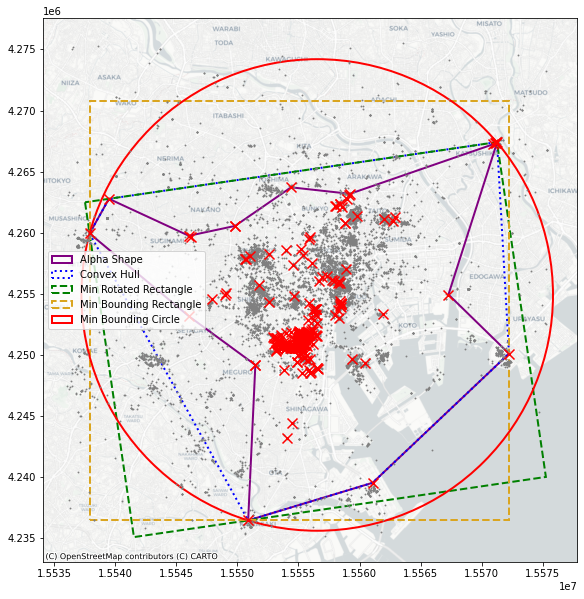

In [52]:
f, ax = plt.subplots(1, figsize=(10, 10))

ax.add_patch(alpha_shape_patch)
ax.add_patch(convex_hull_patch)
ax.add_patch(min_rot_rect_patch)
ax.add_patch(min_rect_patch)
ax.add_patch(circ_patch)

ax.scatter(db.x, db.y, s=0.75, color="grey")
ax.scatter(user.x, user.y, s=100, color="r", marker="x")
ax.legend(ncol=1, loc="center left")

# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
plt.show()

## Randomness & clustering

- Spatial statistics on point patterns are often concerned with how even a distribution of points is. 
-  Whether points tend to all cluster near one another or disperse evenly throughout the problem area.
- quadrat statistics, receive their name after their approach to split the data up into small areas (quadrants). Once created, these “buckets” are used to examinee the uniformity of counts across them. The second set of techniques all derive from Ripley (1988), and involve measurements of the distance between points in a point pattern.

In [60]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

- For the purposes of illustration, it also helps to provide a pattern derived from a known completely spatially random process.

- That is, the location and number of points is totally random; there is neither clustering nor dispersion. In point pattern analysis, this is known as a Poisson point process.
- To simulate these processes from a given point set, you can use the pointpats.random module.

In [62]:
random_pattern = random.poisson(coordinates, size=len(coordinates))

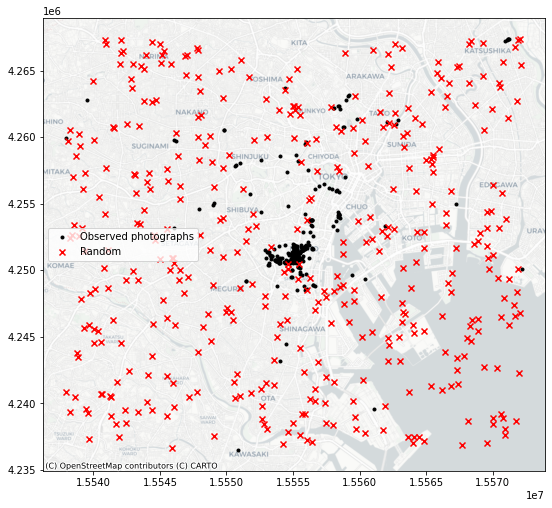

In [63]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observed photographs"
)
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random")
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

In [68]:
random_pattern_ashape = random.poisson(
    alpha_shape, size=len(coordinates)
)

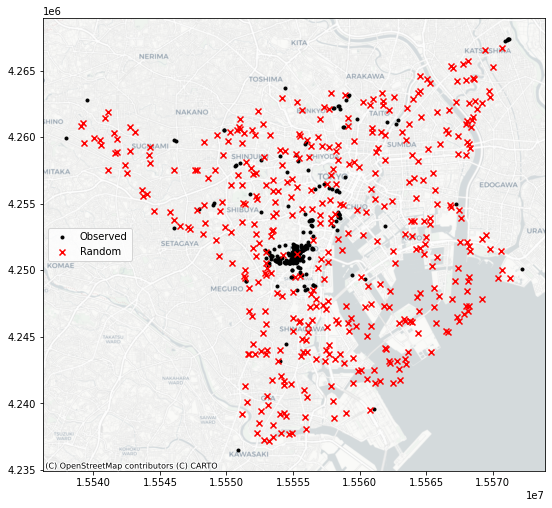

In [69]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(*coordinates.T, color="k", marker=".", label="Observed")
plt.scatter(
    *random_pattern_ashape.T, color="r", marker="x", label="Random"
)
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

## Quadrat statistics

- Quadrat statistics examine the spatial distribution of points in an area in terms of the count of observations that fall within a given cell.

- By examining whether observations are spread evenly over cells,
    the quadrat approach aims to estimate whether points are spread out, or if they are clustered into a few cells. Strictly speaking, quadrat statistics examine the evenness of the distribution over cells using a 
    χ2 statistical test common in the analysis of contingency tables.
    


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


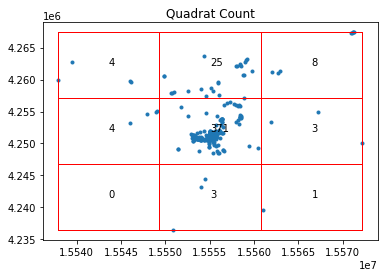

In [70]:
qstat = QStatistic(coordinates)
qstat.plot()

 - we see that the central square has over 350 observations, but the surrounding cells have many fewer Flickr photographs.

- the chi-squared test (which compares how likely this distribution is if the cell counts are uniform) will be statistically significant, with a very small p-value:

In [71]:
qstat.chi2_pvalue

0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


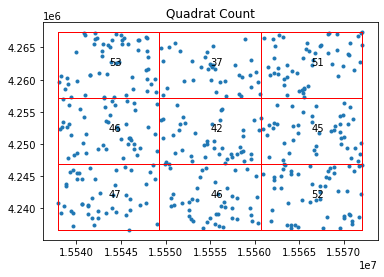

In [75]:
# Random


qstat_null = QStatistic(random_pattern)
qstat_null.plot()

In [76]:
# p-value will be big, not significant

qstat_null.chi2_pvalue

0.8164349561330038

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


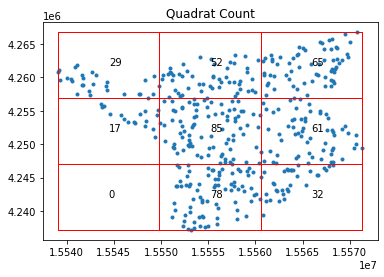

In [77]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()

- The quadrat test finds this to be statistically nonrandom, while our simulating process ensured that within the given study area, the pattern is a complete spatially-random process.

In [78]:
qstat_null_ashape.chi2_pvalue

9.551052965239946e-27

- One way to interpret the quadrat statistic that reconciles cases like the one above is to think of it as a test that considers both the uniformity of points and the shape of their extent to examine whether the resulting pattern is uniform across a regular grid

### Ripley’s alphabet of functions

- The second group of spatial statistics we consider focuses on the distributions of two quantities in a point pattern: nearest neighbor distances and what we will term “gaps” in the pattern.
- Each of these characterize an aspect of the point pattern as we increase the distance range from each point to calculate them.
- The first function, Ripley’s G, focuses on the distribution of nearest neighbor distances. 

- That is, the G function summarizes the distances between each point in the pattern and their nearest neighbor.

- the plot below, this nearest neighbor logic is visualized with the red dots being a detailed view of the point pattern and the black arrows indicating the nearest neighbor to each point. Note that sometimes two points are mutual nearest neighbors (and so have arrows going in both directions) but some are not.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


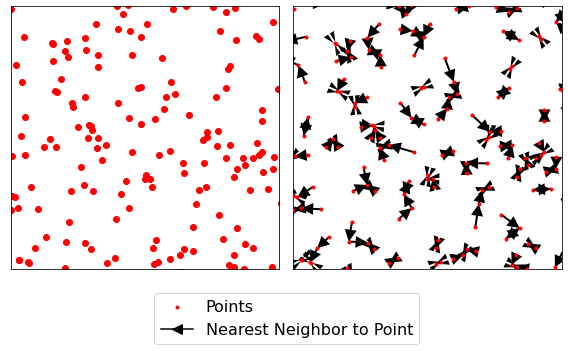

In [81]:

f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(*random_pattern.T, color="red")
ax[1].scatter(
    *random_pattern.T,
    color="red",
    zorder=100,
    marker=".",
    label="Points"
)
nn_ixs, nn_ds = PointPattern(random_pattern).knn(1)
first = True
for coord, nn_ix, nn_d in zip(random_pattern, nn_ixs, nn_ds):
    dx, dy = random_pattern[nn_ix].squeeze() - coord
    arrow = ax[1].arrow(
        *coord,
        dx,
        dy,
        length_includes_head=True,
        overhang=0,
        head_length=300 * 3,
        head_width=300 * 3,
        width=50 * 3,
        linewidth=0,
        facecolor="k",
        head_starts_at_zero=False
    )
    if first:
        plt.plot(
            (1e100, 1e101),
            (0, 1),
            color="k",
            marker="<",
            markersize=10,
            label="Nearest Neighbor to Point",
        )
    first = False

ax[0].axis([1.554e7, 1.556e7, 4240000, 4260000])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
f.tight_layout()
ax[1].legend(bbox_to_anchor=(0.5, -0.06), fontsize=16)
plt.show()

- Ripley’s G keeps track of the proportion of points for which the nearest neighbor is within a given distance threshold, and plots that cumulative percentage against the increasing distance radii. The distribution of these cumulative percentage has a distinctive shape under completely spatially random processes. The intuition behind Ripley’s G goes as follows: we can learn about how similar our pattern is to a spatially random one by computing the cumulative distribution of nearest neighbor distances over increasing distance thresholds, and comparing it to that of a set of simulated patterns that follow a known spatially-random process. Usually, a spatial Poisson point process is used as such reference distribution.

* To do this in the pointpats package, we can use the g_test function, which computes both the G function for the empirical data and these hypothetical replications under a completely spatially random process.

In [85]:
g_test = distance_statistics.g_test(
    coordinates, support=40, keep_simulations=True
)

- Thinking about these distributions of distances, a “clustered” pattern must have more points near one another than a pattern that is “dispersed”; and a completely random pattern should have something in between. Therefore, if the G function increases rapidly with distance, we probably have a clustered pattern. If it increases slowly with distance, we have a dispersed pattern.

- On the left, we plot the G(d) function, with distance-to-point (d) on the horizontal axis and the fraction of nearest neighbor distances smaller than d on the right axis. In red, the empirical cumulative distribution of nearest neighbor distances is shown

* In blue, simulations (like the random pattern shown in the previous section) are shown. The bright blue line represents the average of all simulations, and the darker blue/black band around it represents the middle 95% of simulations.

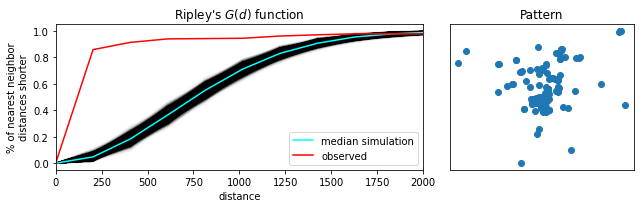

In [86]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    numpy.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

*  The red empirical function rises much faster than simulated completely spatially random patterns. This means that the observed pattern of this user’s Flickr photographs are closer to their nearest neighbors than would be expected from a completely spatially random pattern. The pattern is clustered.

* The second function we introduce is Ripley’s F. Where the G function works by analyzing the distance between points in the pattern, the F function works by analyzing the distance to points in the pattern from locations in empty space

* That is why the F function is called the “the empty space function”, since it characterizes the typical distance from arbitrary points in empty space to the point pattern.

* the 
F
 accumulates, for a growing distance range, the percentage of points that can be found within that range from a random point pattern generated within the extent of the observed pattern. If the pattern has large gaps or empty areas, the 
F
 function will increase slowly. But, if the pattern is highly dispersed, then the 
F
 function will increase rapidly. The shape of this cumulative distribution is then compared to those constructed by calculating the same cumulative distribution between the random pattern and an additional, random one generated in each simulation step.



In [87]:
f_test = distance_statistics.f_test(
    coordinates, support=40, keep_simulations=True
)

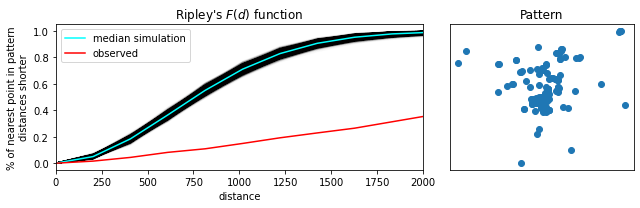

In [88]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# plot all the simulations with very fine lines
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    numpy.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's F function
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

* Since the F function estimated for the observed pattern increases much more slowly than the 
    F functions for the simulated patterns, we can be confident that there are many gaps in our pattern; i.e. the pattern is clustered.

# Identifying clusters

- Let's focus on the existence and location of clusters.

- the methods discussed in this chapter understand points as events that happen in particular locations but that could happen in a much broader set of places

- From the many spatial point clustering algorithms, we will cover one called DBSCAN (Density-Based Spatial Clustering of Applications

- DBSCAN is a widely used algorithm that originated in the area of knowledge discovery and machine learning and that has since spread into many areas, including the analysis of spatial points

-  DBSCAN, a cluster is a concentration of at least m points, each of them within a distance of r of at least another point in the cluster. Following this definition, the algorithm classifies each point in our pattern into three categories:



- Noise, for those points outside a cluster.
- Cores, for those points inside a cluster with at least m points in the cluster within distance r.
- Borders for points inside a cluster with less than m other points in the cluster within distance r.

In [89]:
# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
clusterer.fit(db[["x", "y"]])

DBSCAN()

In [90]:
# Print the first 5 elements of `cs`
clusterer.core_sample_indices_[:5]

array([ 1, 22, 30, 36, 42])

In [93]:
clusterer.labels_[:5]  #labels object always has the same length as the number of points used to run DBSCAN
# Each value represents the index of the cluster a point belongs to. If the point is classified as noise,
#it receives a -1.

array([-1,  0, -1, -1, -1])

In [94]:
lbls = pandas.Series(clusterer.labels_, index=db.index)

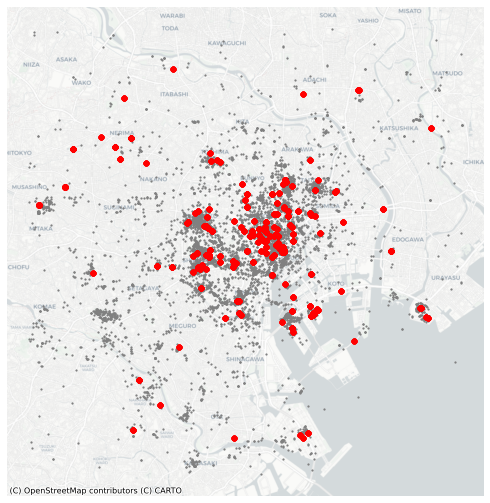

In [95]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

In [96]:
# Way too many points are classified as a noise
#This is because we have run DBSCAN with the default parameters: a radius of 0.5 and a minimum of five points per cluster. 
#Since our data is expressed in meters, a radius of half a meter will only pick up hyper local clusters. 

In [97]:
# Obtain the number of points 1% of the total represents
minp = numpy.round(db.shape[0] * 0.01)
minp

100.0

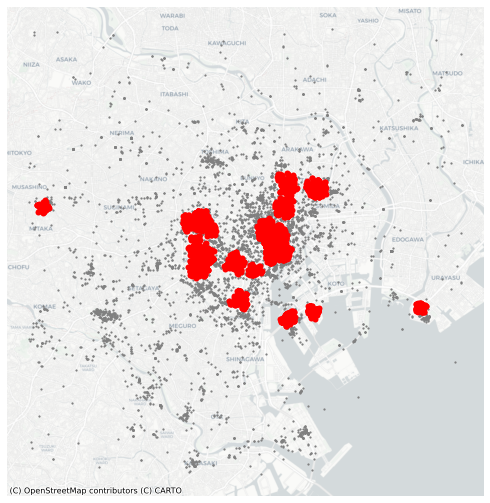

In [98]:
#At the same time, let us expand the maximum radius to say, 500 meters.

# Rerun DBSCAN
clusterer = DBSCAN(eps=500, min_samples=int(minp))
clusterer.fit(db[["x", "y"]])
# Turn labels into a Series
lbls = pandas.Series(clusterer.labels_, index=db.index)
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()